# This notebook is used to model wiggles and precession in jets
The first half is work done by Alice Quillen.

The end of the notebook is work done by Adam Rubinstein. 
Some dependencies stay in the first half, especially the function called "mkarrs_slow", please familiarize yourself with it

In [1]:
import numpy as np
import matplotlib.pyplot as plt

orbit plane is (x,y)

position of jet source as a function of ejection time $t_e$

$x(t_e) = r_0 \cos (\omega_B t_e)$

$y(t_e) = r_0 \sin (\omega_B t_e)$

precessing jet has initial velocity  vector

${\bf v}_j = v_j ( \sin \beta  \cos (\Omega_p t_e - \phi_0),
\sin \beta  \sin (\Omega_p t_e - \phi_0),  \cos \beta )$

together the initial velocity is 

$v_x(t_e)  = -r_0 \omega_B \sin (\omega_B t_e) + v_j  \sin \beta  \cos (\Omega_p t_e - \phi_0)$

$v_y(t_e)  = r_0 \omega_B \cos (\omega_B t_e) + v_j  \sin \beta  \sin (\Omega_p t_e - \phi_0)$

$v_z(t_e)  = v_j \cos \beta$

integrate

$x(t,t_e) = v_x(t_e) (t-t_e) + r_0 \cos (\omega_B t_e)$

$y(t,t_e) = v_y(t_e)  (t-t_e) + r_0 \sin (\omega_B t_e)$

$z(t,t_e) = v_z(t_e)  (t-t_e)$

$r_0$ is position of jet source from center of mass of binary.

$\beta$ is half opening angle of jet angle (angle between jet and orbit normal).

$\Omega_p t_e - \phi_0$ is jet precession angle (jet axis projected onto orbit plane).

$v_j$ is jet velocity. 

$\omega_B$ is mean motion of binary orbit. 

$t_e$ is ejection time for jet blob. 

$x,y,z$ are position of blob at current time $t$.

$\Omega_p$ is jet precession rate.

Choose $x$ axis from orbital plane in plane of sky and $z$ axis in plane of sky.
This means $y$ axis (in orbital plane) is along line of sight. 

Sky coordinates $x_s, y_s, z_s$ where $y_s$ is along line of sight.
For a right handed coordinate system, $z_s$ is to north, $x_s$ is to the right and $y_s$
increases away from viewer.

We want to rotate, so that we can tilt the orbit plane via inclination $i$. 
We rotate in $yz$ plane,   keeping $x$ untouched.

$\begin{pmatrix} x_s \\ y_s \\ z_s \end{pmatrix} = 
\begin{pmatrix} 1 & 0 & 0 \\ 0 & \cos i & \sin i \\   0 & -\sin i & \cos i \end{pmatrix} 
\begin{pmatrix} x \\ y \\ z \end{pmatrix}  = 
\begin{pmatrix} x \\  y \cos iy + z\sin i  \\ -y\sin i  + z\cos i  \end{pmatrix}
$

In [2]:
# set te = array of ejection times, oldest ejection was at te=0
te = np.linspace(0,3e-3,200)  #in Myrs
t = max(te)   # current time is the maximum of possible ejection times
AUtopc = 1.5e13/3.0e18  # from AU to pc
#pc = 3.0e18 # cm
#G = 6.674e-8 # g m^3/s^2
G = 4.30091E-3 #  pc Msol^−1 (km/s)2  # gravitational constant in weird units

# set parms for model
m1 =  1.0 # masses msol, jet source
m2 =  1.0  # mass of secondary msol
a_B_AU = 20.0  # AU binary semi-major axis
beta_deg  = 30.0 # half opening angle for jet in degrees 
phi0 = -np.pi/2  # initial precession phase in radians
vj = 350.0  # jet velocity in km/s
incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 20 # ratio of periods precession to orbital 
PA_deg = 0.0 # position angle on sky to rotate from N, in degrees

#calculate a bunch of arrays
def mkarrs(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg):
    a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
    r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
    # units pc
    # velocity of binary 
    v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
    # note: this is not w.r.t center of mass 
    omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
    beta = beta_deg*np.pi/180  # in radians, opening angle of jet
    # note that r0*omega_B < v_B
    Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    
    #initial ejection velocity 
    vxarr = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr =  vj*np.cos(beta)
    # integrated positions later on
    xarr = vxarr*(t-te) + r0*np.cos(omega_B*te)
    yarr = vyarr*(t-te) + r0*np.sin(omega_B*te)
    zarr = vzarr*(t-te)

    # rotate x,y,z to xs,ys,zs to on sky taking into account orbit inclination
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # also rotate the velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
    # rotate by position angle on sky from N
    PA = PA_deg*np.pi/180.
    
    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr
    
    # return all these arrays
    return xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA

In [3]:

ddin_deg = 5.0  # spacing of inclinations in degrees
#plot a series of different inclinations
def plt_stuff(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,ddin_deg):
    
    # show jet blobs on sky
    fig,axarr = plt.subplots(1,5,figsize=(6,4),sharex=True,sharey=True,dpi=100)
    plt.subplots_adjust(hspace=0,wspace=0)
    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180 # inclination
        # compute arrays
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg)
        # plot positions 
        axarr[i].plot(xsarr_PA,zsarr_PA,'-')
        axarr[i].set_aspect('equal')
    axarr[0].set_ylabel('(pc)')
    axarr[0].set_xlabel('(pc)')
    
    # show velocities proper-motions and radial velocities as a function of projected distance
    fig,axarr = plt.subplots(5,1,figsize=(6,4),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)

    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg)
    
        vpp = np.sqrt(vxsarr**2 + vzsarr**2)  # velocity on sky plane
        dsky = np.sqrt(xsarr**2  + zsarr**2)   # distance on sky from source
        axarr[i].plot(dsky,vpp,'b-')  # plot proper motion
        axarr[i].plot(dsky,vysarr,'g-')  #  plot radial velocity
        #axarr[i].set_aspect('equal')
    axarr[4].set_xlabel('d (pc)')
    axarr[0].set_ylabel(r'$v_{pp}$ (km/s)')

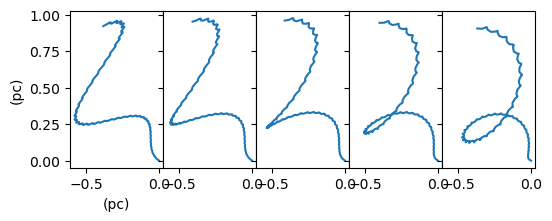

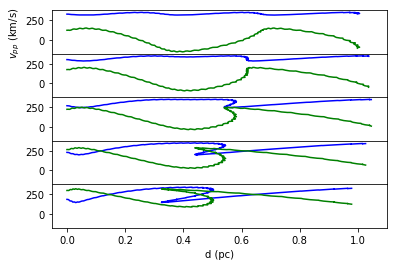

In [4]:
# chose parms 
m1 =  1.0 # masses msol, jet source
m2 =  1.0 # binary companion, msol
a_B_AU = 20.0  # binary semi-major axis in AU
beta_deg  = 25.0 # half opening angle for jet in degrees 
phi0 = 0.5*np.pi/2  # initial precession phase in radians
vj = 350.0  # jet velocity in km/s
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 30 # ratio of periods precession to orbital 
PA_deg = 40.0 # position angle on sky to rotate from N, in degrees

ddin_deg = 10  # in degrees, spacing for inclination changes 
plt_stuff(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,ddin_deg)



In [5]:
# looks like we cannot get proper motion to drop?
# this means that velocity drop is due to slowing down?
#  if so happy feedback result
# what about direction of precession, compared to orbit
# is direction of binary orbit known?

In [6]:
# along knots maybe extinction increases which puts at distance further away from us?


In [7]:
# Should we try a model where we slow down the jet?

In [8]:
junk = np.loadtxt('propermotions.txt')  # read in proper motion table

# convert RA and DEC to radians
def RA_to_rad(RAh,RAm,RAs,DECrad):
    RArad= (RAh + RAm/60. + RAs/(60.*60.)) * 2*np.pi/24
    RArad *= np.cos(DECrad)
    return RArad
    
def DEC_to_rad(DECd,DECm,DECs):
    return (DECd + DECm/60 + DECs/(60.*60))*np.pi/180

RAh=junk[:,0]
RAm=junk[:,1]
RAs=junk[:,2]

DECd= junk[:,3]
DECm= junk[:,4]
DECs= junk[:,5]
DECrad = DEC_to_rad(DECd,DECm,DECs)   # convert to radians
RArad = RA_to_rad(RAh,RAm,RAs,DECrad)
dx_pp = junk[:,12]
dy_pp = junk[:,13]
vprop=junk[:,15]  #km/s
distance = 430.4 # pc, distance to HOPS361(A)

vx = vprop*dx_pp/np.sqrt(dx_pp**2 + dy_pp**2)  #proper motion vector in km/s
vy = vprop*dy_pp/np.sqrt(dx_pp**2 + dy_pp**2)

# 5:47:4.631 +0:21:47.82  #Cheng HOPS361C position
DEC_HOPS361C  = DEC_to_rad(0.0,21.0,47.82)
RA_HOPS361C = RA_to_rad(5.0,47.0,4.631,DEC_HOPS361C)

x = -1*(RArad - RA_HOPS361C)*distance  # position of each knot
y = (DECrad - DEC_HOPS361C)*distance

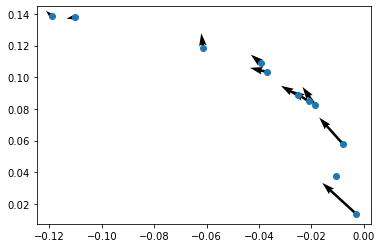

In [9]:
plt.plot(x,y,'o')
plt.quiver(x,y,vx,vy)


Suppose we allow damping 

The initial velocity is still

$v_x(t_e)  = -r_0 \omega_B \sin (\omega_B t_e) + v_j  \sin \beta  \cos (\Omega_p t_e - \phi_0)$

$v_y(t_e)  = r_0 \omega_B \cos (\omega_B t_e) + v_j  \sin \beta  \sin (\Omega_p t_e - \phi_0)$

$v_z(t_e)  = v_j \cos \beta$

However we let the velocity amplitude drop with travel time  
${\bf v}(t,t_e) = {\bf v}(t_e) e^{-\alpha (t-t_e)} $

integrate

${\bf x} = {\bf x}_0 + \frac{ {\bf v}(t_e)}{\alpha} (1 -  e^{-\alpha (t-t_e)} ) $

$x(t,t_e) = v_x(t_e) \frac{1}{\alpha}(1 - e^{-\alpha (t-t_e)}) + r_0 \cos (\omega_B t_e)$

$y(t,t_e) = v_y(t_e)  \frac{1}{\alpha}(1 - e^{-\alpha (t-t_e)}) + r_0 \sin (\omega_B t_e)$

$z(t,t_e) = v_z(t_e)  \frac{1}{\alpha}(1 - e^{-\alpha (t-t_e)}) $


In [10]:
def precession_period(a_B_AU,m1,m2,Omega_p_fac):
    a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
    r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
    # units pc
    # velocity of binary 
    v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
    # note: this is not w.r.t center of mass 
    omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
    Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 
    P = 2.0*np.pi/Omega_p
    #print('P = {:.5f} Myr'.format(P))
    return P


In [11]:
#Make a set of arrays for a single model
# parameters
# m1,m2 masses
# a_B_AU binary semi
# beta_deg half openning angle
# phi0 initial phase for precession
# incl inclination of orbit plane
# Omega_p_fac sets precession rate
# te array of ejection times in Myrs
# t should be max of te (current time)
# PA_deg is position angle in deg
# alpha damping parm units Myr-1
def mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha):
    beta = beta_deg*np.pi/180  # in radians, opening angle of jet
    a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
    r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
    # units pc
    # velocity of binary 
    v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
    # note: this is not w.r.t center of mass 
    omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
    # note that r0*omega_B < v_B
    Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)
    
    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac
    
    # integrated positions
    slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha
    xarr = vxarr_e*slow_fac + r0*np.cos(omega_B*te)
    yarr = vyarr_e*slow_fac + r0*np.sin(omega_B*te)
    zarr = vzarr_e*slow_fac

    # rotate x,y,z to xs,ys,zs
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
    # rotate by position angle on sky from N
    PA = PA_deg*np.pi/180.
    
    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr
    
    return xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA


#plot different inclinations
def plt_stuff_slow(m1,m2,a_B_AU,beta_deg,phi0,Omega_p_fac,te,t,PA_deg,alpha,ddin_deg):
    
    # show jet blobs on sky
    fig,axarr = plt.subplots(1,5,figsize=(6,4),sharex=True,sharey=True,dpi=100)
    plt.subplots_adjust(hspace=0,wspace=0)
    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
        axarr[i].plot(xsarr_PA,zsarr_PA,'-')
        axarr[i].set_aspect('equal')
    axarr[0].set_ylabel('(pc)')
    axarr[0].set_xlabel('(pc)')
    
    # show velocities propermotions and radial ones as a function of projected distance
    fig,axarr = plt.subplots(5,1,figsize=(6,4),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)

    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
    
        vpp = np.sqrt(vxsarr**2 + vzsarr**2)  # velocity on sky plane
        dsky = np.sqrt(xsarr**2  + zsarr**2)   # distance on sky from source
        axarr[i].plot(dsky,vpp,'b-')  #proper motion
        axarr[i].plot(dsky,vysarr,'g-')  # radial velocity
        #axarr[i].set_aspect('equal')
    axarr[4].set_xlabel('d (pc)')
    axarr[0].set_ylabel(r'$v_{pp}$ (km/s)')
    
    
    
#plot different inclinations
# along with data
# here x,y, are positions of knots
# vprop are proper motions in km/s
def plt_stuff_slow_data(m1,m2,a_B_AU,beta_deg,phi0,Omega_p_fac,te,t,PA_deg,alpha,ddin_deg,x,y,vprop):
    
    # show jet blobs on sky
    fig,axarr = plt.subplots(1,5,figsize=(6,4),sharex=True,sharey=True,dpi=100)
    plt.subplots_adjust(hspace=0,wspace=0)
    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
        im=axarr[i].scatter(xsarr_PA,zsarr_PA,c=ysarr,s=5,cmap='viridis')
        axarr[i].set_aspect('equal')
        axarr[i].plot(x,y,'ro',ms=3)
    axarr[0].set_ylabel('(pc)')
    axarr[0].set_xlabel('(pc)')
    cax = fig.add_axes([0.93, 0.3, 0.015, 0.3])
    fig.colorbar(im, cax=cax)
    
    # show velocities propermotions and radial ones as a function of projected distance
    fig,axarr = plt.subplots(5,1,figsize=(6,4),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)

    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
    
        vpp = np.sqrt(vxsarr**2 + vzsarr**2)  # velocity on sky plane
        dsky = np.sqrt(xsarr**2  + zsarr**2)   # distance on sky from source
        axarr[i].plot(dsky,vpp,'b-')  #proper motion
        axarr[i].plot(dsky,vysarr,'g-')  # radial velocity
        axarr[i].plot(np.sqrt(x**2 + y**2), vprop,'ro')
        #axarr[i].set_aspect('equal')
    axarr[4].set_xlabel('d (pc)')
    axarr[0].set_ylabel(r'$v_{pp}$ (km/s)')

P_precession = 1848 yr
1/alpha 625.00 yr


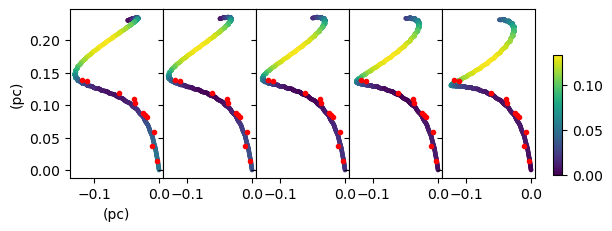

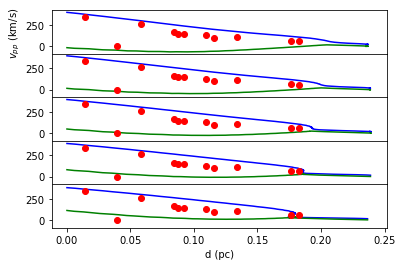

In [12]:
# Here is a good model!!!!!
# set te = array of ejection times, oldest ejection was at te=0
te = np.linspace(-2.0e-3,0,800)  #in Myrs, ejection times
#t = max(te)   # current time is the maximum of possible ejection times
# which should be 0 
t=0

# chose parms again!
m1 =  2.0 # masses msol, jet source
m2 =  0.5 #  companion mass msol
a_B_AU = 20.0  # AU
beta_deg  = 17.0 # half opening angle for jet in degrees 
phi0 = 0.1*np.pi/2  # precession phase in radians, at current time
vj = 400.0  # jet velocity in km/s
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 30.5 # ratio of periods precession to orbital 
PA_deg = 25.0 # position angle on sky to rotate from N, in degrees
alpha=1600. # how fast to slow velocity down, units Myr-1
P = precession_period(a_B_AU,m1,m2,Omega_p_fac)
print('P_precession = {:.0f} yr'.format(P*1e6))
print('1/alpha {:.2f} yr'.format(1/alpha *1e6))

ddin_deg = 5.0  # in degrees, how to step in inclination 

plt_stuff_slow_data(m1,m2,a_B_AU,beta_deg,phi0,Omega_p_fac,te,t,PA_deg,alpha,ddin_deg,x,y,vprop)

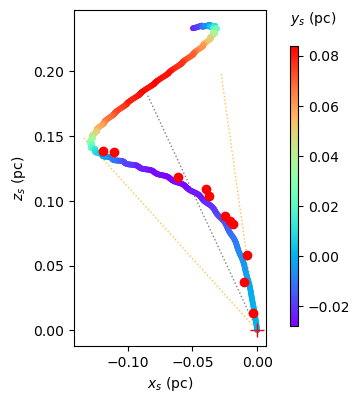

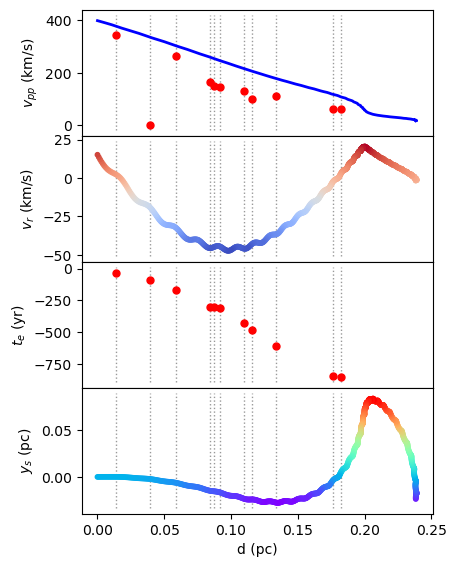

In [13]:
# show a best model, xy plane only
def show_modelxy(m1,m2,a_B_AU,beta_deg,phi0,incl_deg,Omega_p_fac,te,t,PA_deg,alpha,x,y,vprop,ofile):
    # show jet blobs on sky
    fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=100,facecolor='white')
    #ax1 = fig.add_axes[0.1,0.1,0.5,0.5]
    plt.subplots_adjust(hspace=0.1,wspace=0.1,top=0.99,right=0.90,bottom=0.15,left=0.10)
    
    ax.plot(0,0,'r+',ms=10,zorder=3)  #hops361C  +
    dpc = np.sqrt(x**2 + y**2) 
    fac = 1.1
    njetx = np.cos(PA_deg*np.pi/180.0 + np.pi/2)*max(dpc)*fac
    njety = np.sin(PA_deg*np.pi/180.0 + np.pi/2)*max(dpc)*fac
    ax.plot([0,njetx],[0,njety],':',alpha=0.5,lw=1,zorder=1,color='black')  #central axis
    
    njetx1 = np.cos((PA_deg+beta_deg)*np.pi/180.0 + np.pi/2)*max(dpc)*fac
    njety1 = np.sin((PA_deg+beta_deg)*np.pi/180.0 + np.pi/2)*max(dpc)*fac
    njetx2 = np.cos((PA_deg-beta_deg)*np.pi/180.0 + np.pi/2)*max(dpc)*fac
    njety2 = np.sin((PA_deg-beta_deg)*np.pi/180.0 + np.pi/2)*max(dpc)*fac
    ax.plot([0,njetx1],[0,njety1],':',alpha=0.7,lw=1,zorder=1,color='orange')  #central axis + openning angle
    ax.plot([0,njetx2],[0,njety2],':',alpha=0.7,lw=1,zorder=1,color='orange')  #central axis + openning angle
    
    incl = incl_deg*np.pi/180  # make model
    xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)

    im=ax.scatter(xsarr_PA,zsarr_PA,c=ysarr,s=10,cmap='rainbow',zorder=2)  # model
    ax.set_aspect('equal')
    ax.plot(x,y,'ro',ms=6,zorder=3)  #data
    ax.set_ylabel(r'$z_s$ (pc)')
    ax.set_xlabel(r'$x_s$ (pc)')
    cax = fig.add_axes([0.80, 0.2, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    cax.text(0,0.093,r'$y_s$ (pc)')
    
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=250)
    
def show_model_rest(m1,m2,a_B_AU,beta_deg,phi0,incl_deg,Omega_p_fac,te,t,PA_deg,alpha,x,y,vprop,ofile):
    fig,axarr = plt.subplots(4,1,figsize=(4.5,6),dpi=100,sharex=True,facecolor='white')
    plt.subplots_adjust(hspace=0.0,wspace=0.0,top=0.99,right=0.98,bottom=0.15,left=0.2)
    
    incl = incl_deg*np.pi/180  #make model
    xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
    
    # find times of knots in model
    dpc = np.sqrt(x**2 + y**2) # distance on sky of knots
    klist = np.zeros(0,dtype=int)
    for k in range(len(x)):
        dmod2 =  (x[k]-xsarr)**2 + (y[k]-zsarr)**2  # find closest point in model to data
        kmin = np.argmin(dmod2)
        klist = np.append(klist,kmin)

    vpp  = np.sqrt(vxsarr**2 + vzsarr**2) # velocity on sky plane
    dsky = np.sqrt(xsarr**2 + zsarr**2)   # distance on sky from source
    
    i=0
    axarr[i].plot(dsky,vpp,'b-',zorder=2,lw=2)  #proper motion
    axarr[i].plot(dpc, vprop,'ro',zorder=3,ms=5)  #data
    axarr[i].set_ylabel(r'$v_{pp}$ (km/s)')
    
    i=1
    #axarr[i].plot(dsky,vysarr,'g-',zorder=2,lw=2)  # radial velocity
    axarr[i].scatter(dsky,vysarr,c=vysarr,s=10,cmap='coolwarm',zorder=2)
    axarr[i].set_xlabel('d (pc)')
    axarr[i].set_ylabel(r'$v_{r}$ (km/s)')
    
    i=2
    for k in range(len(klist)):
        kmin = klist[k]
        axarr[i].plot(dpc[k],te[kmin]*1e6,'ro',zorder=2,ms=5)
    axarr[i].set_ylabel(r'$t_e$ (yr)')
    
    i=3
    #axarr[i].plot(dsky,ysarr,'c-',zorder=2,lw=2)
    axarr[i].scatter(dsky,ysarr,c=ysarr,s=10,cmap='rainbow',zorder=2)
    axarr[i].set_ylabel(r'$y_s$ (pc)')
    axarr[i].set_xlabel('d (pc)')
    
    
    for i in range(4):
        ylow,yhigh = axarr[i].get_ylim()
        for k in range(len(klist)):
            axarr[i].plot([dpc[k],dpc[k]],[ylow,yhigh],'k:',alpha=0.4,zorder=1,lw=1)  # dotted lines
    
    
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=250)
    
    
ofile="modxy.png"
incl_deg=5.0
show_modelxy(m1,m2,a_B_AU,beta_deg,phi0,incl_deg,Omega_p_fac,te,t,PA_deg,alpha,x,y,vprop,ofile)

ofile="modv.png"
show_model_rest(m1,m2,a_B_AU,beta_deg,phi0,incl_deg,Omega_p_fac,te,t,PA_deg,alpha,x,y,vprop,ofile)


Radial distance from central axis is 

$r(t) = v_j \sin(\beta) t $

and this means that radial velocity from central axis is 

$\dot r = v_j \sin(\beta) $

which is constant. 

That means that we want to compare 

$\dot r$ with the sound speed which is 1 km/s.

Let $v_j$ = 300 km/s.  
Then $\dot r \sim \beta\ 300\ {\rm km/s}  $

$1^\circ = 0.017$

$$\dot r \sim 5 \ {\rm km/s} \left(\frac{v_j}{300 \ {\rm km/s}} \right)
\left( \frac{\beta}{1^\circ} \right)
$$

We find that any jet that is a few hundred km/s and a few degrees wide openning angle
would require motions above the sound speed to fill in.

We suspect that there will be a shortage of long jets with large openning angles because of this. 

The damping distance is about 0.2 pc.

Unless jets have narrow openning angles, they will be damped locally within 0.2 pc of driving source. 

P_precession = 2439 yr
1/alpha 555.56 yr
twindow = 2.03e-04


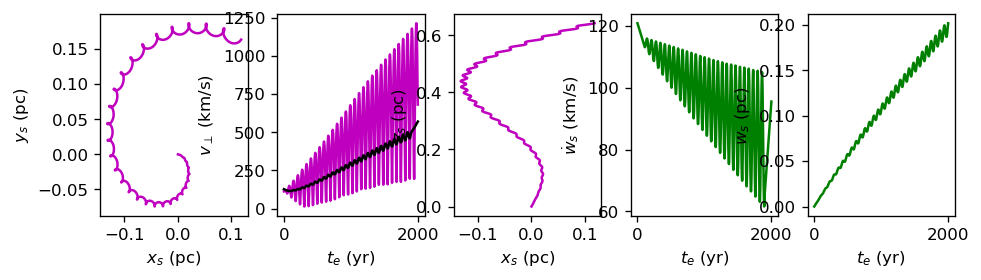

In [14]:
from scipy.signal import savgol_filter 

# show a best model, xy plane only
def show_model_vperp(m1,m2,a_B_AU,beta_deg,phi0,Omega_p_fac,te,t,alpha,ofile):
    # show jet blobs on sky
    fig,axarr = plt.subplots(1,5,figsize=(8,2),dpi=120,facecolor='white')
    #ax1 = fig.add_axes[0.1,0.1,0.5,0.5]
    plt.subplots_adjust(hspace=0.2,wspace=0.2,top=0.99,right=0.99,bottom=0.15,left=0.10)
    
    # make model with zero inclination and 0 pa
    incl = 0.0;PA_deg = 0.0
    
    xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
    
    
    #velocity in xy plane which is perpendicular to jet axis which is along z
    vxy = np.sqrt(vxsarr**2 + vysarr**2)
    # maybe instead we want to know the speed of the knot as estimated from the knot position?
    dt = np.abs(te[1]-te[0])
    dvx = np.gradient(xsarr)/dt
    dvy = np.gradient(ysarr)/dt
    dvz = np.gradient(zsarr)/dt
    wxy = np.sqrt(xsarr**2 + ysarr**2)

    dv = np.sqrt(dvx**2+dvy**2)
    window_length = 81; polyorder=2
    dvxs = savgol_filter(xsarr, window_length, polyorder,deriv=1)/dt
    dvys = savgol_filter(ysarr, window_length, polyorder,deriv=1)/dt
    dws = savgol_filter(wxy, window_length, polyorder,deriv=1)/dt
    twindow = window_length*dt
    print('twindow = {:.2e}'.format(twindow))
    dvs = np.sqrt(dvxs**2+dvys**2)
    axarr[0].plot(xsarr,ysarr,'m-')
    axarr[0].set_ylabel(r'$y_s$ (pc)')
    axarr[0].set_xlabel(r'$x_s$ (pc)')
    
    axarr[2].plot(xsarr,zsarr,'m-')
    axarr[2].set_ylabel(r'$z_s$ (pc)')
    axarr[2].set_xlabel(r'$x_s$ (pc)')
    #axarr[3].plot(ysarr,zsarr,'m-')
    #axarr[3].set_ylabel(r'$z_s$ (pc)')
    #axarr[3].set_xlabel(r'$y_s$ (pc)')
    
    axarr[3].plot(-te*1e6,-dws,'g-')
    axarr[3].set_xlabel(r'$t_e$ (yr)')
    axarr[3].set_ylabel(r'$\dot w_s$ (km/s)')
    
    
    axarr[4].plot(-te*1e6,wxy,'g-')
    axarr[4].set_xlabel(r'$t_e$ (yr)')
    axarr[4].set_ylabel(r'$w_s$ (pc)')
    
    axarr[1].plot(-te*1e6,dv,'m-')
    axarr[1].plot(-te*1e6,dvs,'k-')
    axarr[1].set_xlabel(r'$t_e$ (yr)')
    axarr[1].set_ylabel(r'$v_\perp$ (km/s)')
    
    
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=250)
        
        
        
# set te = array of ejection times, oldest ejection was at te=0
te = np.linspace(-2.0e-3,0,800)  #in Myrs
t = max(te)   # current time is the maximum of possible ejection times

# chose parms again!
m1 =  1.0 # masses msol, jet source
m2 =  1.0 #  companion mass msol
a_B_AU = 20.0  # AU
beta_deg  = 17.0 # half opening angle for jet in degrees 
phi0 = 0.1*np.pi/2  # initial precession phase in radians
vj = 400.0  # jet velocity in km/s
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 36. # ratio of periods precession to orbital 
#PA_deg = 25.0 # position angle on sky to rotate from N, in degrees
alpha=1800. # how fast to slow velocity down, units Myr-1
P = precession_period(a_B_AU,m1,m2,Omega_p_fac)
print('P_precession = {:.0f} yr'.format(P*1e6))
print('1/alpha {:.2f} yr'.format(1/alpha *1e6))

ofile=""
show_model_vperp(m1,m2,a_B_AU,beta_deg,phi0,Omega_p_fac,te,t,alpha*0.1,ofile)


P_precession = 599 yr
1/alpha 555.56 yr
twindow = 2.03e-04


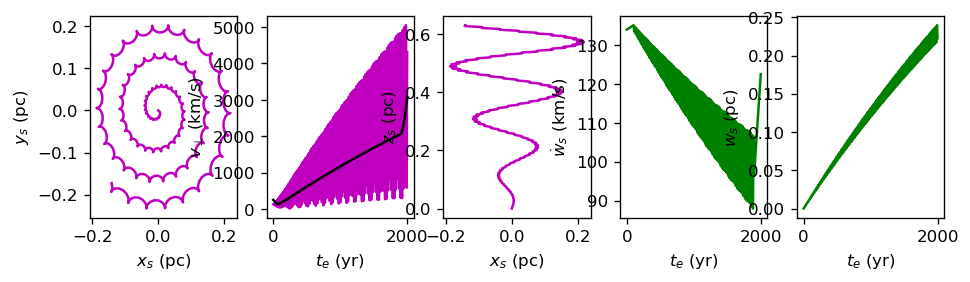

In [15]:
# set te = array of ejection times, oldest ejection was at te=0
te = np.linspace(-2.0e-3,0,800)  #in Myrs
t = max(te)   # current time is the maximum of possible ejection times

# chose parms again!
m1 =  1.0 # masses msol, jet source
m2 =  1.0 #  companion mass msol
a_B_AU = 10.0  # AU
beta_deg  = 20.0 # half opening angle for jet in degrees 
phi0 = 0.1*np.pi/2  # initial precession phase in radians
vj = 400.0  # jet velocity in km/s
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 25. # ratio of periods precession to orbital 
PA_deg = -25.0 # position angle on sky to rotate from N, in degrees
alpha=1800. # how fast to slow velocity down, units Myr-1
P = precession_period(a_B_AU,m1,m2,Omega_p_fac)
print('P_precession = {:.0f} yr'.format(P*1e6))
print('1/alpha {:.2f} yr'.format(1/alpha *1e6))

ofile=""
show_model_vperp(m1,m2,a_B_AU,beta_deg,phi0,Omega_p_fac,te,t,alpha*0.1,ofile)

In [16]:
print(1 *np.pi/180 *300)

5.235987755982989


# Remaking and configuring figures for paper

In [17]:
# Here is a good model!!!!!
# set te = array of ejection times, oldest ejection was at te=0
te = np.linspace(-2e-3,0,800)  #in Myrs, ejection times
#t = max(te)   # current time is the maximum of possible ejection times # which should be 0 
t=0

# choose params
m1 =  1.0 # masses msol, jet source
m2 =  1 #  companion mass msol
a_B_AU = 20.0  # binary semi-major axis au
beta_deg  = 14.5 #17.0 # half opening angle for jet in degrees 
phi0 = 12.8 # 14.0 * np.pi/180. #np.pi/2.0  # precession phase in radians, at current time
vj = -325.0  # jet velocity in km/s + note sign
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = -30.5 # -28.25 # ratio of periods precession to orbital + note sign
PA_deg = 180+23.5 # 23.5+180 # 18.0+180 # position angle on sky to rotate from N, in degrees + note 180 deg
alpha= 1560 # 1700 #1600. # how fast to slow velocity down, units Myr-1
P = precession_period(a_B_AU,m1,m2,Omega_p_fac)
print('P_precession = {:.0f} yr'.format(P*1e6))
print('1/alpha {:.2f} yr'.format(1/alpha *1e6))

incl_deg=0 #inclination in degrees


#compute model
incl = incl_deg*np.pi/180  #converted to radians for model
xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
        mkarrs_slow(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)

# find times of knots in model
dpc = np.sqrt(x**2 + y**2) # distance on sky of knots
klist = np.zeros(0,dtype=int)
for k in range(len(x)):
    dmod2 =  (x[k]-xsarr)**2 + (y[k]-zsarr)**2  # find closest point in model to data
    kmin = np.argmin(dmod2)
    klist = np.append(klist,kmin)

vpp  = np.sqrt(vxsarr**2 + vzsarr**2) # velocity on sky plane
dsky = np.sqrt(xsarr**2 + zsarr**2)   # distance on sky from source

P_precession = -2066 yr
1/alpha 641.03 yr


In [18]:
#Av data, taken from measurements_by_hand when putting together tables
Av_list = np.array([30.2658, 24.0487, 9.60311, 15.9761, 17.1154, 20.325, 30.7061, 31.4283, 20.7581, 7.70811, 1.91259])
#median values work better...otherwise need some sorta cutoff...?
Av_uncert_list = np.array([1.62917, 1.48497, 3.84992, 0.731258, 0.672574, 0.967529, 1.80339, 1.12745, 2.03989, 8.7811, 8.74607])

#using the Av values from C18O emission measured by Iwata et al 1988
# Av_C18O = ((0.84+0.28*6) + 0.4) / (0.21)
Av_C18O = 14.55
Av_cloudback = Av_C18O + np.max(Av_list)

# #testing extrema in cases where the C18O value can vary in worst case scenario...
# print(np.max(Av_list) + ((0.84+0.28*6) + 0.4 - 0.1) / (0.21 + 0.01))
# print(np.max(Av_list) + ((0.84+0.28*6) + 0.4 + 0.1) / (0.21 - 0.01))
# print(Av_cloudback - (np.max(Av_list) + ((0.84+0.28*6) + 0.4 - 0.1) / (0.21 + 0.01)))
# print(Av_cloudback - (np.max(Av_list) + ((0.84+0.28*6) + 0.4 + 0.1) / (0.21 - 0.01)))
# #this implies the denominator can be +1.09 or -1.20...so mean uncertainty of about 1.15
# #this also means we must add 1.15 to all the Av_uncert_list values
# Av_uncert_list += 1.15
Av_uncert_list += 1.6 #found from the C18O value on average

#to check
print(Av_list)
print(Av_uncert_list)
print(Av_C18O)
print(Av_list / Av_cloudback)

[30.2658  24.0487   9.60311 15.9761  17.1154  20.325   30.7061  31.4283
 20.7581   7.70811  1.91259]
[ 3.22917   3.08497   5.44992   2.331258  2.272574  2.567529  3.40339
  2.72745   3.63989  10.3811   10.34607 ]
14.55
[0.6582627  0.52304457 0.20886179 0.34747044 0.37224952 0.44205636
 0.66783896 0.68354637 0.45147602 0.16764669 0.04159767]


3.422271293214361


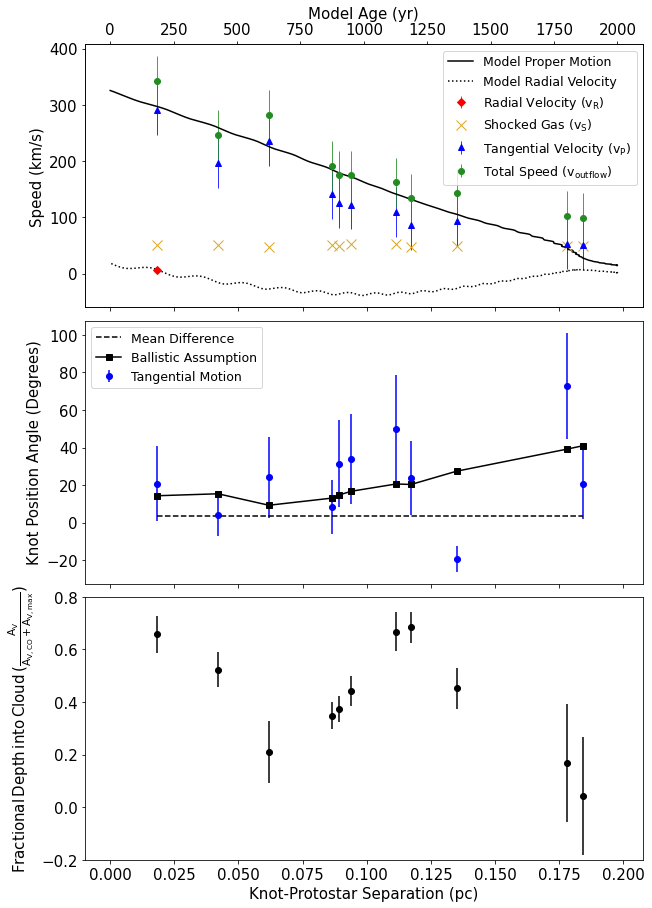

In [19]:
#values taken from measurements in measurements_by_hand when making tables for SPEEDS!

#distances to help with fit
knot_source_dist = [0.01822046, 0.04205783, 0.06185785, 0.08663537, 0.08924019, \
                       0.09395867, 0.11148708, 0.11723194, 0.13494519, 0.17807351, 0.18420528]

#observed total (?) motions
# vobs = np.array([348.6, 248.6, 277.4 , 177.2, 140, 133.9, 99.7, 101.2, 112.3, 32.1, 61.4])
df_cc_tanspeeds = np.array([290.7, 196.9, 235.6, 141.2, 125.5, 122.4, 109.6,  85.8,  93.4, 52.4,  51.1])

#shock speeds
shock_avgspeed_list = np.array([51.62423015183755, \
 50.19106600766818, \
 46.94501870077839, \
 50.948835518487996, \
 49.052335863117186, \
 52.292500213274984, \
 52.56264891558462, \
 47.77942447274933, \
 49.31377439546969, \
 49.773454304513365, \
 48.52457446394419])

#observed proper motions
vobs = df_cc_tanspeeds + shock_avgspeed_list
# np.array([320.3, 226.6, 279.2, 178.1, 161.1, 151.2, 137.3, 115.9, 127.3, 97.4,  94.2])

#plotting
fig, ax = plt.subplots(3,1, figsize=(10, 15), sharex=True)

#observed values
radvel=6.2 #km/s
radvelerr = 1 #km/s
ax[0].errorbar(knot_source_dist[0], radvel, yerr=radvelerr, color='red', marker='D', label=r'$\rm Radial \ Velocity \ (v_R)$', linestyle='', linewidth=0.8) #radial velocity
ax[0].errorbar(knot_source_dist, shock_avgspeed_list, color='goldenrod', marker='x', markersize=10, label=r'$\rm Shocked \ Gas \ (v_S)$', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, df_cc_tanspeeds, yerr=44, color='blue', marker='^', label=r'$\rm Tangential \ Velocity \ (v_P)$', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, vobs, yerr=44, color='forestgreen', marker='o', label=r'$\rm Total \ Speed \ (v_{outflow})$', linestyle='', linewidth=0.8)


#theoretical or model values
i=0
ax[i].plot(dsky,vpp, color='black', linestyle='-', label='Model Proper Motion')  #proper motion, order can be set with zorder?
ax[i].plot(dsky,vysarr, color='black', linestyle=':', label='Model Radial Velocity')  # radial velocity

#time axis on top
ax2 = ax[0].twiny()
ax2.plot(np.abs(te)*1e6, vpp, linestyle='')
ax2.set_xlabel('Model Age (yr)', fontsize=15)
ax2.tick_params(axis='x', labelsize=15)

#y-axis, speed formats
# ax[0].set_ylim(-100, 500) 
ax[0].set_ylabel('Speed (km/s)', fontsize=15)
# ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='best', fontsize=12.5)


#plotting angular values, taken from measurements_by_hand, where we make plots with arrows and measure values for tables
theta_list = np.array([20.807492661774326, 3.8875640056588026, 24.04520066559546, 8.306060176494071, 31.353669272203476, \
              33.68689179064716, 49.600172563087185, 23.6576880775022, -19.213207462652136, 72.75761084119398, \
              20.59155455385345])
theta_uncert_list = [19.7570761530857, 11.273633581505138, 21.35089360497203, 14.242262107087974, 23.21284652324617, \
                     24.00162309094273, 29.02534614243301, 19.85639952465575, \
                     6.897477658536189, 28.464611270185067, 18.73886356399794]
knot_source_pa = np.array([14.31128073, 15.3584063,   9.25337468, 13.08573056, 14.73487355, 16.70694884,
                     20.59027569, 20.3167963,  27.36926166, 39.16356146, 40.94520315,])

ax[1].errorbar(knot_source_dist, theta_list, yerr=np.abs(theta_uncert_list), color='blue', label='Tangential Motion', linestyle='', marker='o')

# ax[1].scatter(knot_source_sep, theta_list-knot_source_pa, color='black') #plotting difference between theory and observation
print(np.mean(theta_list-knot_source_pa))
ax[1].plot(knot_source_dist, [np.mean(theta_list-knot_source_pa)] * len(knot_source_dist), color='black', linestyle='--', label='Mean Difference')
ax[1].plot(knot_source_dist, knot_source_pa, color = 'black', marker='s', label='Ballistic Assumption')

ax[1].set_ylabel('Knot Position Angle (Degrees)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].legend(loc='upper left', fontsize=12.5)


#now plotting fractional depths
ax[2].errorbar(knot_source_dist, Av_list/Av_cloudback, yerr=Av_uncert_list/Av_cloudback, \
               marker='o', linestyle='', color='black') #observation
ax[2].set_ylabel(r'$\rm Fractional \,  Depth \, into \, Cloud \, (\frac{{A}_{V}}{{A}_{V,CO} + {A}_{V,max}})$', fontsize=15)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].set_ylim(-0.2, 0.8)
# ax2.set_xlim(0, 0.2)
# ax[2].invert_xaxis() #and RA increasing left, needs to be done last

#formatting x-axis, saved it for last
ax[2].set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax[2].tick_params(axis='x', labelsize=15)
plt.subplots_adjust(hspace=0.05)

#saving
plt.savefig('speed_dist_trends.png', dpi=300, bbox_inches="tight")
plt.savefig('speed_dist_trends.pdf', dpi=300, bbox_inches="tight")

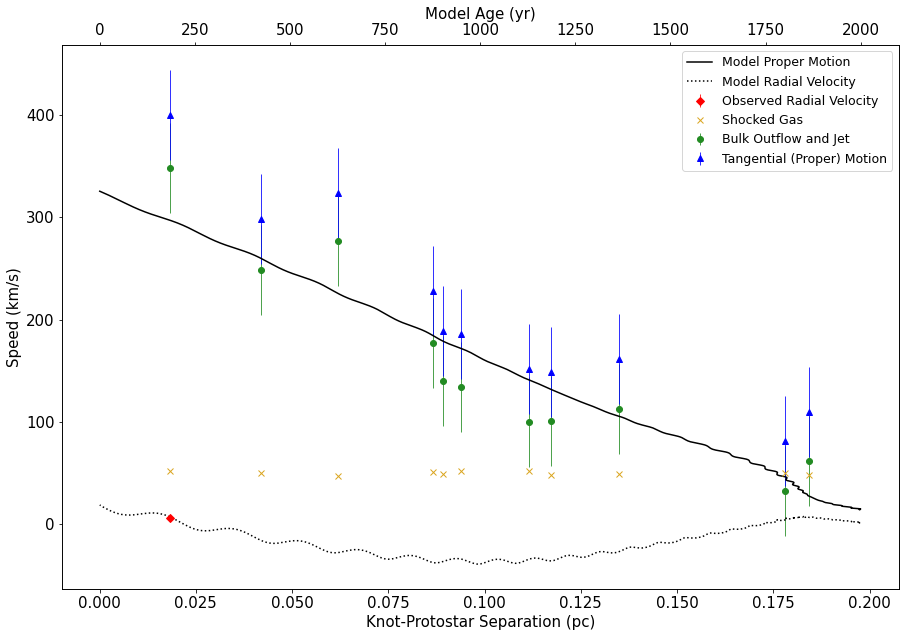

In [20]:
#values taken from measurements in measurements_by_hand when making tables for SPEEDS!

#distances to help with fit
knot_source_dist = [0.01822046, 0.04205783, 0.06185785, 0.08663537, 0.08924019, \
                       0.09395867, 0.11148708, 0.11723194, 0.13494519, 0.17807351, 0.18420528]

#observed total (?) motions
vobs = np.array([348.6, 248.6, 277.4 , 177.2, 140, 133.9, 99.7, 101.2, 112.3, 32.1, 61.4])

#shock speeds
shock_avgspeed_list = np.array([51.62423015183755, \
 50.19106600766818, \
 46.94501870077839, \
 50.948835518487996, \
 49.052335863117186, \
 52.292500213274984, \
 52.56264891558462, \
 47.77942447274933, \
 49.31377439546969, \
 49.773454304513365, \
 48.52457446394419])

#observed proper motions
df_cc_tanspeeds = vobs+shock_avgspeed_list

#plotting
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)

#observed values
radvel=6.2 #km/s
radvelerr = 1 #km/s
ax.errorbar(knot_source_dist[0], radvel, yerr=radvelerr, color='red', marker='D', label='Observed Radial Velocity', linestyle='', linewidth=0.8) #radial velocity
ax.errorbar(knot_source_dist, shock_avgspeed_list, color='goldenrod', marker='x', label='Shocked Gas', linestyle='', linewidth=0.8)
ax.errorbar(knot_source_dist, vobs, yerr=44, color='forestgreen', marker='o', label='Bulk Outflow and Jet', linestyle='', linewidth=0.8)
ax.errorbar(knot_source_dist, df_cc_tanspeeds, yerr=44, color='blue', marker='^', label='Tangential (Proper) Motion', linestyle='', linewidth=0.8)


#theoretical or model values
i=0
ax.plot(dsky,vpp, color='black', linestyle='-', label='Model Proper Motion')  #proper motion, order can be set with zorder?
ax.plot(dsky,vysarr, color='black', linestyle=':', label='Model Radial Velocity')  # radial velocity

#time axis on top
ax2 = ax.twiny()
ax2.plot(np.abs(te)*1e6, vpp, linestyle='')
ax2.set_xlabel('Model Age (yr)', fontsize=15)
ax2.tick_params(axis='x', labelsize=15)

#y-axis, speed formats
# ax[0].set_ylim(-100, 500) 
ax.set_ylabel('Speed (km/s)', fontsize=15)
# ax[0].get_xaxis().set_visible(False)
ax.tick_params(axis='y', labelsize=15)
ax.legend(loc='best', fontsize=12.5)

#formatting x-axis, saved it for last
ax.set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.subplots_adjust(hspace=0.05)

#saving
plt.savefig('poster_speed_trends.png', dpi=300, bbox_inches="tight")
plt.savefig('poster_speed_trends.pdf', dpi=300, bbox_inches="tight")

In [21]:
#grabbing ds9 region data for all knots, needed to be measured first (usually in measurements_by_hand)
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images

#known pixel size
hst_pixsize = 0.12825 #arcsec

f2 = open('../measurements_by_hand/epoch2_361c_byhand_ellipses_ordered.reg', 'r')
file1_output = []
file2_output = []

#looping through file 
for line in f2:
    file2_output.append(line)
f2.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file2_output = [i[8:-2] for i in file2_output[3:]]

#next step is for image, loop through all regions and make a list of region properties
rad_a_list = []
rad_b_list = []
rotation_list = []

#coordinate details
split_params2 = [i.split(',') for i in file2_output]

#aperture size details
n2071_dist = 430.4 #pc
rad_a_list = np.array([float(rad_a2[2][:-1])*n2071_dist/206265. for rad_a2 in split_params2])
rad_b_list = np.array([float(rad_b2[3][:-1])*n2071_dist/206265. for rad_b2 in split_params2])
rotation_list = np.array([float(rot2[4]) for rot2 in split_params2])

In [22]:
#measurements of h2 knots from walther & geballe 2019 made by hand; need to convert from RA,Dec to physical positions

#measurements from spreadsheet
h2_ra_list = [(5,47,4.7), (5,47,4.73), (5,47,4.85), (5,47,5.0213), (5,47,5.7128), (5,47,6.1277), (5,47,6.3638), \
    (5,47,7.6213), (5,47,7.9574)]
h2_dec_list = [(0,21,50), (0,22,5), (0,22,14), (0,22,24.809), (0,22,26.851), (0,22,29.447), (0,22,40.851), \
    (0,22,41.894), (0,22,45.532)]

#loop through them and append to a list to convert to pc
h2_xlist = []
h2_ylist = []
for i in range(len(h2_ra_list)):
    #read in data
    dec_d, dec_m, dec_s = h2_dec_list[i]
    ra_h, ra_m, ra_s = h2_ra_list[i]
    
    #convert to rads with function
    h2_DEC_rad = DEC_to_rad(dec_d, dec_m, dec_s)
    h2_RA_rad = RA_to_rad(ra_h, ra_m, ra_s,h2_DEC_rad)

    h2_ylist.append((h2_DEC_rad - DEC_HOPS361C)*distance)
    h2_xlist.append(-1*(h2_RA_rad - RA_HOPS361C)*distance)  # position of each knot


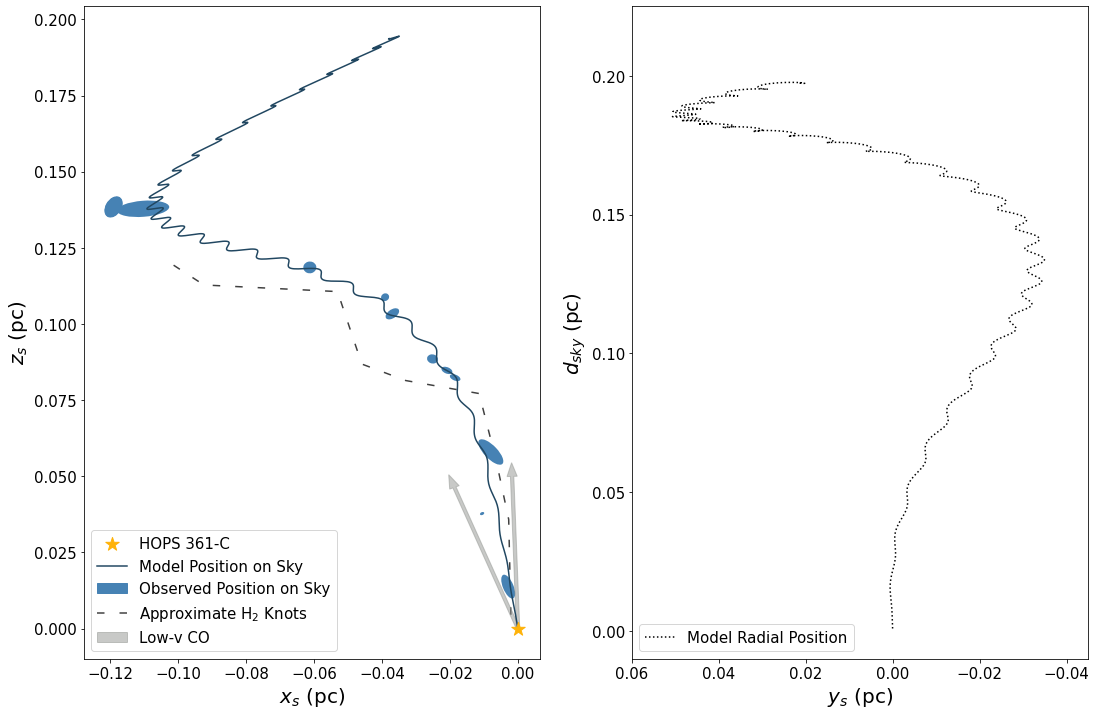

In [37]:
# show a best model, xy plane only
# show jet blobs on sky
fig,ax = plt.subplots(1,2,figsize=(18,12))
#ax1 = fig.add_axes[0.1,0.1,0.5,0.5]
# plt.subplots_adjust(hspace=0.1,wspace=0.1,top=0.99,right=0.90,bottom=-0.0,left=0.10)

#panel 1, the view of our model on the sky
i = 0
ax[i].scatter(0,0,c='xkcd:saffron',marker='*', s=200, label='HOPS 361-C', zorder=100)  #hops361C  *, the star

#if you want to look at the half opening angle
# dpc = np.sqrt(x**2 + y**2) 
fac = -1.1
njetx = np.cos(PA_deg*np.pi/180.0 + np.pi/2)*max(knot_source_dist)*fac
njety = np.sin(PA_deg*np.pi/180.0 + np.pi/2)*max(knot_source_dist)*fac
# ax[i].plot([0,njetx],[0,njety],':',alpha=0.5,lw=1,zorder=1,color='black')  #central axis

njetx1 = np.cos((PA_deg+beta_deg)*np.pi/180.0 + np.pi/2)*max(knot_source_dist)*fac
njety1 = np.sin((PA_deg+beta_deg)*np.pi/180.0 + np.pi/2)*max(knot_source_dist)*fac
njetx2 = np.cos((PA_deg-beta_deg)*np.pi/180.0 + np.pi/2)*max(knot_source_dist)*fac
njety2 = np.sin((PA_deg-beta_deg)*np.pi/180.0 + np.pi/2)*max(knot_source_dist)*fac
# ax[i].plot([0,njetx1],[0,njety1],':',alpha=0.7,lw=1,zorder=1,color='black')  #central axis + openning angle
# ax[i].plot([0,njetx2],[0,njety2],':',alpha=0.7,lw=1,zorder=1,color='black')  #central axis + openning angle

# model
im=ax[i].plot(xsarr_PA, zsarr_PA, color='xkcd:dark slate blue', label='Model Position on Sky')  


#observations
from matplotlib.patches import Ellipse
# ax[i].scatter(y, x, color='black', label='Observed Position on Sky')  #data
for j in range(len(rotation_list)):
    ax[i].add_patch(Ellipse(xy=(x[j], y[j]), width=rad_b_list[j]*2, height=rad_a_list[j]*2, angle=rotation_list[j]+90, \
                   facecolor='steelblue', alpha=1))
ax[i].add_patch(Ellipse(xy=(x[j], y[j]), width=rad_b_list[j]*2, height=rad_a_list[j]*2, angle=rotation_list[j]+90, \
                   color='steelblue', alpha=1, label='Observed Position on Sky'))


#plotting h2 cavity from walther & geballe 2019
ax[i].plot(h2_xlist, h2_ylist, linestyle='--', alpha=0.75, color='black', label=r'$\rm Approximate \ H_2 \ Knots$', \
           dashes=(5,10), zorder=-1)
# ax[i].scatter(h2_xlist, h2_ylist, alpha=0.5, color='red', marker='x', label=r'$\rm H_2 \ Knots$')

#plotting arrows representing the radio jet and CO cavity
angles_list = np.array([92, 112]) #high v and radio jet: 105, 96
x_orig = [0] * len(angles_list) #start arrow at origin, creates length 4 list of number in brackets
y_orig = [0] * len(angles_list)
mag = 0.05
x_direct = mag * np.cos(angles_list * np.pi / 180.) #using trig as x = R*cos(theta)
y_direct = mag * np.sin(angles_list * np.pi / 180.)
color_list = ['xkcd:gray', 'xkcd:gray'] #high v and radio jet: 'goldenrod', 'limegreen'
jet_label_list = ['Low-v CO', ''] #'High-v CO', 'Radio Jet'
for n in range(len(angles_list)):
    ax[i].arrow(x_orig[n], y_orig[n], x_direct[n], y_direct[n], alpha = 0.5, \
                color=color_list[n], label=jet_label_list[n], zorder=1)


#some formatting
ax[i].set_ylabel(r'$z_s$ (pc)', fontsize=20)
ax[i].set_xlabel(r'$x_s$ (pc)', fontsize=20)
ax[i].legend(loc='lower left', fontsize=15)


#panel 2, the radial or line of sight view through the cloud produced by our model
i=1
ax[i].set_ylabel(r'$ {d}_{sky}$ (pc)', fontsize=20)
# ax2 = ax[i].twiny()
#axarr[i].plot(dsky,ysarr,'c-',zorder=2,lw=2)
ax[i].plot(ysarr+100, dsky+100, color='black', linestyle=':', label='Model Radial Position') #theory
ax[i].plot(ysarr, dsky, color='black', linestyle=':') #theory

#observed Av ratio axis on side...
# ax[i].errorbar(100*Av_list[0]/Av_cloudback, 100*knot_source_dist[0], xerr=Av_uncert_list[0]/Av_cloudback, linestyle='', color='steelblue', marker='o', \
#                 label=r'Observed $\rm \frac{{A}_{V}}{{A}_{V,CO} + {A}_{V,max}}$') #to cheat the legend...?
#                label=r'Observed $\rm \frac{{A}_{V,knot}}{%d \times {A}_{V,CO} + max({A}_{V,knot})}$'%scale_denom) #to cheat the legend...?
        
# ax[i].errorbar(dpc, Av_list/Av_cloudback-np.mean(Av_list/Av_cloudback), \
#                yerr=Av_uncert_list/Av_cloudback, \
#                marker='o', linestyle='', color='black') #observation
# ax[i].errorbar(Av_list/Av_cloudback, knot_source_dist, xerr=Av_uncert_list/Av_cloudback, \
#                marker='o', linestyle='', color='steelblue') #observation


#updating tick sizes and other formatting...
#panel 1
# ax[0].invert_yaxis() #done because it's nicer with declination increasing going up
# ax[0].set_xlim(-0.01, 0.175)
# ax[0].set_ylim(-0.13, 0.01)
# ax[0].invert_yaxis()
# ax[0].invert_xaxis()
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)

#panel 2
ax[1].set_ylim(-0.01, 0.225)
# ax[1].set_xlim(-0.3, 1)
# ax[1].set_xlabel('Fractional Depth', fontsize=20)
ax[1].set_xlabel(r'$ y_s$ (pc)', fontsize=20)
ax[1].set_xlim(-0.045, 0.06) #for the twin axis
ax[1].tick_params(axis='x', labelsize=15)
ax[1].invert_xaxis()
# ax[1].invert_xaxis()
# ax[1].invert_yaxis()
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].legend(loc='lower left', fontsize=15)

#saving figure
# ax[0].set_aspect('equal')
plt.savefig('positional_fits.png', dpi=300, bbox_inches="tight")
plt.savefig('positional_fits.pdf', dpi=300, bbox_inches="tight")